In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
prcp_data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

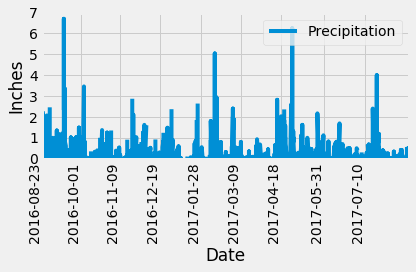

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])

precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y-%m-%d')

precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(xlim=('2016-08-23','2017-08-23'), ylim=(0,7), rot=90)

plt.legend(loc='upper right')
plt.xticks(('2016-08-23', '2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10'))
plt.yticks((0,1,2,3,4,5,6,7))

plt.xlabel('Date')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Station.id).distinct().count()
stations_available

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations[0][0]
most_active_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                          func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

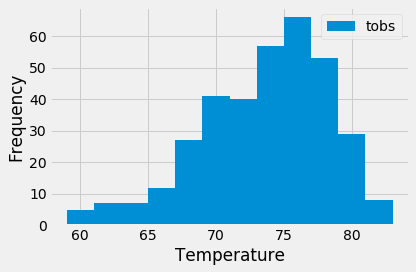

In [19]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).first()
highest_temp_obs_station = highest_temp_obs_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == highest_temp_obs_station).all()

temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

temperature_df.plot(kind='hist', bins=12)

plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2017-07-30','2017-08-04')
trip_data

[(72.0, 78.71428571428571, 84.0)]

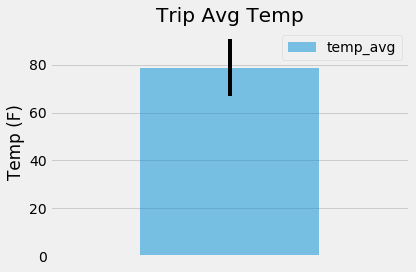

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_data, columns=['temp_min','temp_avg','temp_max'])

trip_df.plot(kind='bar', y='temp_avg', yerr=(trip_df['temp_max'] - trip_df['temp_min']), title='Trip Avg Temp', alpha=0.5)

plt.xticks(np.arange(1, 1.0))
plt.ylabel('Temp (F)')

plt.tight_layout()
plt.savefig('Images/tripavgtemp.png')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = '2017-07-30'
trip_end = '2017-08-04'
sel = [Measurement.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= trip_start)\
                    .filter(Measurement.date <= trip_end).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
results

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6100000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.22),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-30'
end_date = '2017-08-04'
# Use the start and end date to create a range of dates
trip_dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
                .group_by(Measurement.date).all()
trip_dates = [date[0] for date in trip_dates]

# Stip off the year and save a list of %m-%d strings
trip_dates_mod = [date[5:] for date in trip_dates]

normals = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_dates_mod:
    normals.append(daily_normals(date))

daily_norms = []
for row in range(len(normals)):
    daily_norms.append(normals[row][0])
daily_norms

[(69.0, 77.35185185185185, 84.0),
 (72.0, 77.03571428571429, 83.0),
 (67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(daily_norms, columns=['temp_min', 'temp_avg', 'temp_max'])

normals_df['date'] = trip_dates
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')

normals_df.set_index('date', inplace=True)

normals_df

,temp_min,temp_avg,temp_max
date,,,
2017-07-30,69.0,77.351852,84.0
2017-07-31,72.0,77.035714,83.0
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0


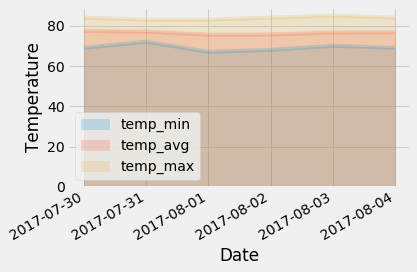

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True)

plt.xlabel('Date')
plt.ylabel('Temperature')

plt.tight_layout()
plt.savefig('Images/tripdailynormals.png')
plt.show()